## Questions:

* Alluvial plots -- what statistical tests to perform?

In [1]:
import os 
import pandas as pd
import numpy as np
from itertools import combinations, product
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix 
from lib import *

from scipy.stats import chi2_contingency

def chi2test(ds, t1, t2, day):

    ds1 = pd.DataFrame(ds.loc[(ds['Session_y'] == day) & (ds['treatment'] == t1), 'CellType_y'].value_counts(sort = False)).reset_index()
    ds2 = pd.DataFrame(ds.loc[(ds['Session_y'] == day) & (ds['treatment'] == t2), 'CellType_y'].value_counts(sort = False)).reset_index()
    cont_table = pd.merge(ds1, ds2, on = 'index').set_index('index').values

    res = chi2_contingency(cont_table)
    pval = res[1]
    return pval

sessions = [2, 6, 7, 9]
str_sessions = [str(x) for x in sessions]
events = ['ReSpout_pos', 'ReSpout_neg', \
       'UnSpout_pos', 'UnSpout_neg', 'ReMid_pos', 'ReMid_neg', 'UnMid_pos', \
       'UnMid_neg']
       
fn_in = './data/input/explore2.csv'
df = pd.read_csv(fn_in)
conditions = df.treatment.unique()
n_cond = len(conditions)
n_animals = 3

In [2]:
def mutual_info(x, y, n_cat = 2, labels = None):
    mi = 0
    N = len(x)
    if N == 0: return 0
    assert len(x) == len(y)
    
    if labels is None:
        iterator1 = range(n_cat)
        iterator2 = range(n_cat)
        x = x.astype(int)
        y = y.astype(int)
    else:
        iterator1 = labels 
        iterator2 = labels

    for i in iterator1:
        for j in iterator2:
            pij = sum((x == i) & (y == j))/N
            pi = sum(x == i)/N
            pj = sum(y == j)/N
            if (pij == 0) or (pi == 0) or (pj == 0): continue
            mi += pij*np.log2(pij/pi/pj)
    return mi

In [3]:
# Identify rewarded cells on day 6
pairs = [(6,7), (6,9)]

def track_history(df, pairs, celltype = 'Rewarded'):

    ds_tracked = pd.DataFrame()

    #Find cells that can be tracked through day 6 and 7, and 6 and 9
    for pair in pairs:
        for treatment in conditions:
            animals = df.loc[df.treatment == treatment, "Animal"].unique()
            for animal in animals:
                df_con = df[(df.treatment == treatment) & (df.Animal == animal)]
                _, cell_stats, _, animals = compute_stats(df, treatment)
                cell_fully_tracked = [k for k,v in cell_stats[animal].items() if (v[1] == 1 and v[2] == 1)]
                #print("cells tracked between pair", pair, ":", len(cell_fully_tracked), 'out of', len(cell_stats[animal]))
                _ = df_con.CellType.unique()
                s_1, s_2 = pair            

                ds1 = df_con.loc[df_con.Session == s_1].set_index('MatchID')
                ds1 = ds1[ds1.index.isin(cell_fully_tracked)]
                ds1 = ds1.loc[ds1['CellType'] == celltype]
                
                ds2 = df_con.loc[df_con.Session == s_2].set_index('MatchID')
                ds2 = ds2[ds2.index.isin(cell_fully_tracked)]
                ds = pd.merge(ds1, ds2, on = ['Animal', 'MatchID', 'treatment'])
                ds = ds[['recording_x', 'recording_y', 'Animal', 'Session_x', 'Session_y', 'treatment', 'CellType_y']]
                ds_tracked = ds_tracked.append(ds)
    return ds_tracked

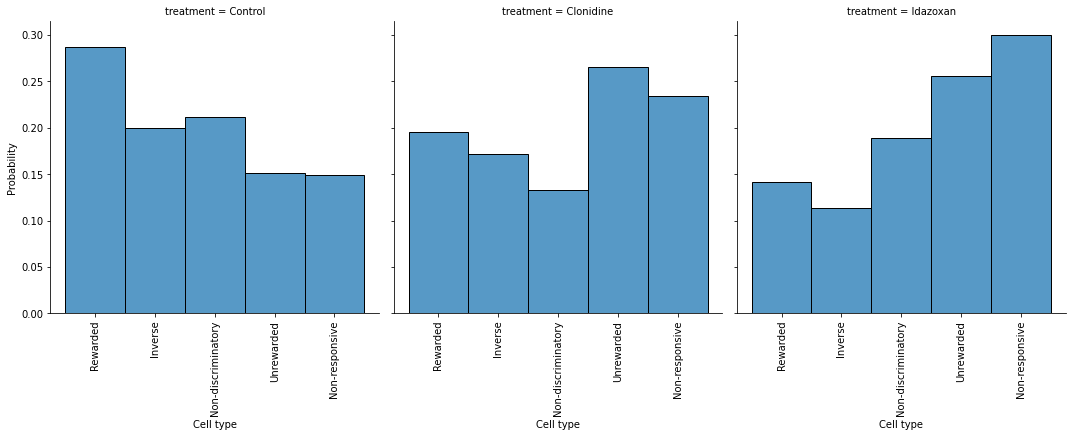

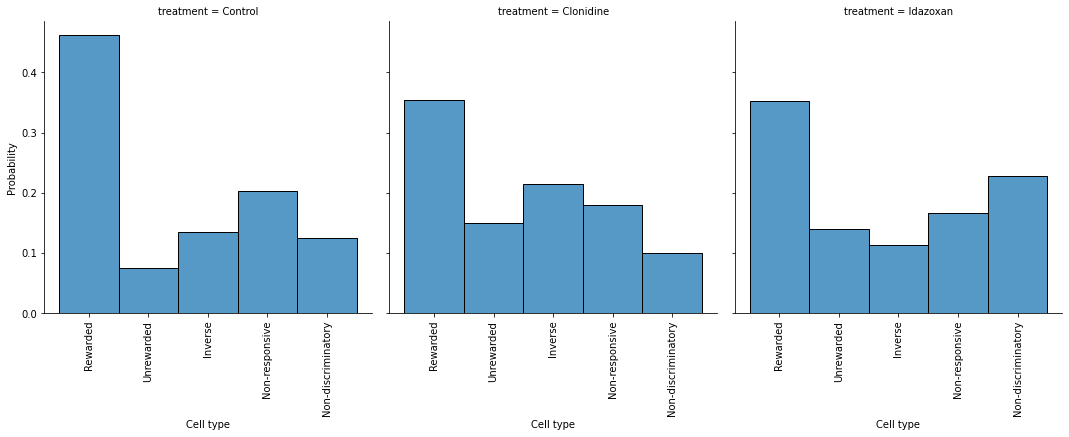

In [4]:
ds_tracked = track_history(df, pairs, celltype = 'Rewarded')
dplot = sns.displot(ds_tracked[ds_tracked['Session_y'] == 7], x = 'CellType_y', col = 'treatment', stat = 'probability', common_norm = False, height = 5)
dplot.fig.axes[0].tick_params(axis='x', rotation=90)
dplot.fig.axes[0].set_xlabel("Cell type")
dplot.fig.axes[1].tick_params(axis='x', rotation=90)
dplot.fig.axes[1].set_xlabel("Cell type")
dplot.fig.axes[2].tick_params(axis='x', rotation=90)
dplot.fig.axes[2].set_xlabel("Cell type");
#dplot.fig.suptitle("Classification of 'rewarded cells on day 6', on day 7")

dplot = sns.displot(ds_tracked[ds_tracked['Session_y'] == 9], x = 'CellType_y', col = 'treatment', kind = 'hist', stat = 'probability', common_norm = False)
dplot.fig.axes[0].tick_params(axis='x', rotation=90)
dplot.fig.axes[0].set_xlabel("Cell type")
dplot.fig.axes[1].tick_params(axis='x', rotation=90)
dplot.fig.axes[1].set_xlabel("Cell type")
dplot.fig.axes[2].tick_params(axis='x', rotation=90)
dplot.fig.axes[2].set_xlabel("Cell type");
#dplot.fig.suptitle("Classification of 'rewarded cells on day 6', on day 9")

Statistical tests

In [5]:
print("Day 7")
print('Control vs Clonidine', chi2test(ds_tracked, 'Control', 'Clonidine', 7))
print('Control vs Idazoxan', chi2test(ds_tracked, 'Control', 'Idazoxan', 7))
print('Idazoxan vs Clonidine', chi2test(ds_tracked, 'Clonidine', 'Idazoxan', 7))

print("Day 9")
print('Control vs Clonidine', chi2test(ds_tracked, 'Control', 'Clonidine', 9))
print('Control vs Idazoxan', chi2test(ds_tracked, 'Control', 'Idazoxan', 9))
print('Idazoxan vs Clonidine', chi2test(ds_tracked, 'Clonidine', 'Idazoxan', 9))


Day 7
Control vs Clonidine 4.521969018856712e-08
Control vs Idazoxan 1.1966933183619456e-12
Idazoxan vs Clonidine 0.00176283377019765
Day 9
Control vs Clonidine 0.00034118715041837124
Control vs Idazoxan 0.0005081541475149456
Idazoxan vs Clonidine 2.5347852364038315e-05


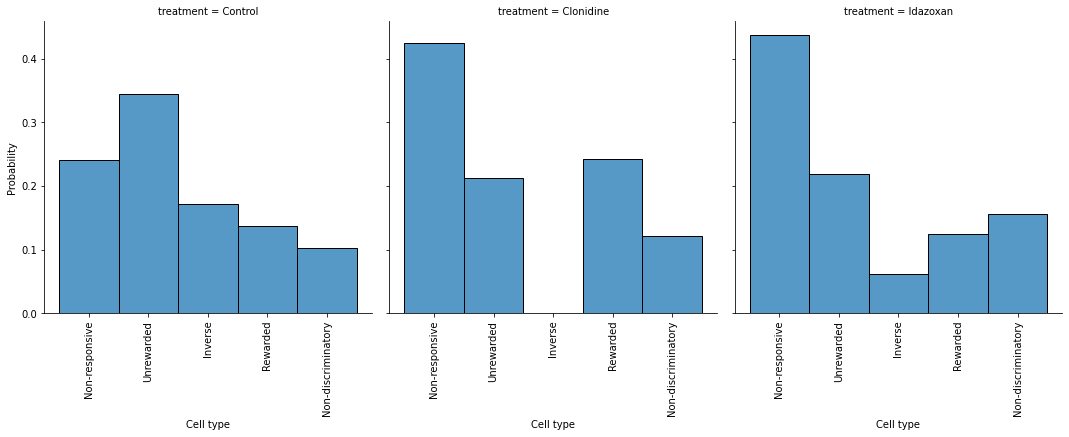

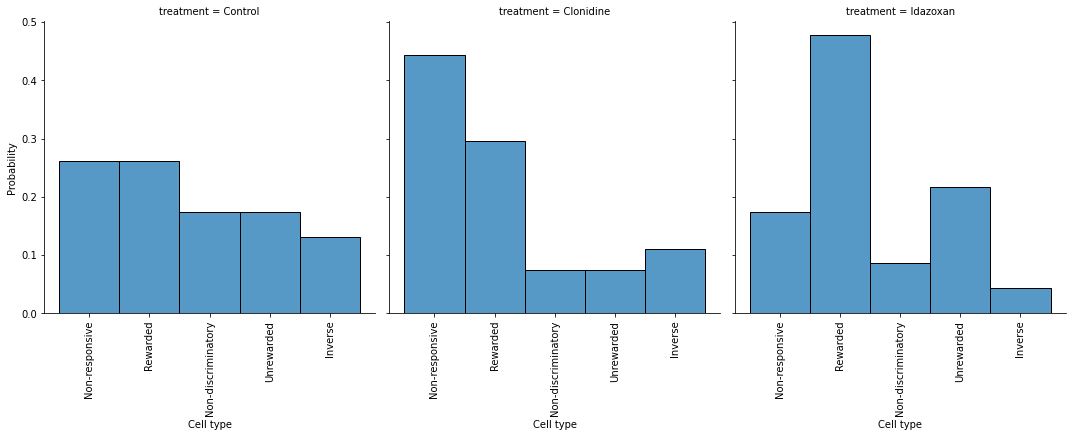

In [6]:
ds_tracked = track_history(df, pairs, celltype = 'Unrewarded')
dplot = sns.displot(ds_tracked[ds_tracked['Session_y'] == 7], x = 'CellType_y', col = 'treatment', stat = 'probability', common_norm = False, height = 5)
dplot.fig.axes[0].tick_params(axis='x', rotation=90)
dplot.fig.axes[0].set_xlabel("Cell type")
dplot.fig.axes[1].tick_params(axis='x', rotation=90)
dplot.fig.axes[1].set_xlabel("Cell type")
dplot.fig.axes[2].tick_params(axis='x', rotation=90)
dplot.fig.axes[2].set_xlabel("Cell type");
#dplot.fig.suptitle("Classification of 'rewarded cells on day 6', on day 7")

dplot = sns.displot(ds_tracked[ds_tracked['Session_y'] == 9], x = 'CellType_y', col = 'treatment', kind = 'hist', stat = 'probability', common_norm = False)
dplot.fig.axes[0].tick_params(axis='x', rotation=90)
dplot.fig.axes[0].set_xlabel("Cell type")
dplot.fig.axes[1].tick_params(axis='x', rotation=90)
dplot.fig.axes[1].set_xlabel("Cell type")
dplot.fig.axes[2].tick_params(axis='x', rotation=90)
dplot.fig.axes[2].set_xlabel("Cell type");
#dplot.fig.suptitle("Classification of 'rewarded cells on day 6', on day 9")

In [7]:
print("Day 7")
print('Control vs Clonidine', chi2test(ds_tracked, 'Control', 'Clonidine', 7))
print('Control vs Idazoxan', chi2test(ds_tracked, 'Control', 'Idazoxan', 7))
print('Idazoxan vs Clonidine', chi2test(ds_tracked, 'Clonidine', 'Idazoxan', 7))

print("Day 9")
print('Control vs Clonidine', chi2test(ds_tracked, 'Control', 'Clonidine', 9))
print('Control vs Idazoxan', chi2test(ds_tracked, 'Control', 'Idazoxan', 9))
print('Idazoxan vs Clonidine', chi2test(ds_tracked, 'Clonidine', 'Idazoxan', 9))


Day 7
Control vs Clonidine 0.39278484438165184
Control vs Idazoxan 0.3411469114390059
Idazoxan vs Clonidine 0.7280539970673692
Day 9
Control vs Clonidine 0.5057227347302885
Control vs Idazoxan 0.45568026666769845
Idazoxan vs Clonidine 0.16599933881512702
